# Import libraries and data

In [ ]:
# Importing necessary packages 

## General libraries

import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
import datetime
import time
import seaborn as sns

## Machine Learning libraries
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_regression, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from xgboost import XGBClassifier

import tensorflow as tf
import gensim
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import string
from string import punctuation
import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df_train = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/clean_merged_data_train.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)
df_test = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/clean_merged_data_test.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)
df_val = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/clean_merged_data_val.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)

In [ ]:
df_train['fake_news'].value_counts()

0    4782
1    1917
Name: fake_news, dtype: int64

In [ ]:
df_test['fake_news'].value_counts()

0    1837
1     730
Name: fake_news, dtype: int64

# Data Cleaning for NLP - titles

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet=WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
title_train = list()
titles = df_train['title'].values.tolist()

for title in titles:
    # tokenize the text
    tokens = word_tokenize(title)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    title_train.append(lemma)
    
title_train[0:5]

[['kate',
  'middleton',
  'introduces',
  'mental',
  'health',
  'film',
  'paying',
  'attention',
  'small',
  'feeling'],
 ['topless',
  'activist',
  'crash',
  'woody',
  'allen',
  'concert',
  'germany',
  'protest',
  'sexual',
  'violence'],
 ['jax',
  'taylor',
  'brittany',
  'cartwright',
  'lala',
  'kent',
  'slam',
  'james',
  'kennedy'],
 ['jon',
  'hamm',
  'slam',
  'social',
  'medium',
  'visual',
  'equivalent',
  'masturbating'],
 ['bachelor',
  'star',
  'nick',
  'viall',
  'vanessa',
  'grimaldi',
  'speak',
  'split']]

In [ ]:
validation_split = 0.2
max_length = 8

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(title_train)
sequences = tokenizer_obj.texts_to_sequences(title_train)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  df_train['fake_news'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

#n_values = np.max(category) + 1
#Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = category[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = category[-num_validation_samples:]

unique tokens - 8921
vocab_size - 8922


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (5360, 8)
Shape of y_train: (5360,)
Shape of X_test_pad: (1339, 8)
Shape of y_test: (1339,)


# GloVe Models

### GloVe Model 1 -  LSTM

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_txt = '/content/gdrive/My Drive/243/glove.6B.50d.txt'
f = open(glove_txt, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=8,
                            trainable=False)

In [ ]:
model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(32,  dropout=0.2, recurrent_dropout=0.25))
model_glove.add(Dense(1, activation='sigmoid'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_glove.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 50)             446100    
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 456,757
Trainable params: 10,657
Non-trainable params: 446,100
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')



In [ ]:
hist = model_glove.fit(X_train_pad, y_train, batch_size = 64, epochs = 20, validation_data = (X_test_pad, y_test), callbacks=[checkpoint], verbose=1)


Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.7084
Epoch 1: val_accuracy improved from -inf to 0.72293, saving model to model-001-0.722928.h5
84/84 [==============================] - 14s 41ms/step - loss: 0.5931 - accuracy: 0.7082 - val_loss: 0.5549 - val_accuracy: 0.7229
Epoch 2/20
82/84 [============================>.] - ETA: 0s - loss: 0.5421 - accuracy: 0.7308
Epoch 2: val_accuracy improved from 0.72293 to 0.74160, saving model to model-002-0.741598.h5
84/84 [==============================] - 2s 24ms/step - loss: 0.5400 - accuracy: 0.7315 - val_loss: 0.5329 - val_accuracy: 0.7416
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.7498
Epoch 3: val_accuracy improved from 0.74160 to 0.74981, saving model to model-003-0.749813.h5
84/84 [==============================] - 2s 28ms/step - loss: 0.5163 - accuracy: 0.7498 - val_loss: 0.5187 - val_accuracy: 0.7498
Epoch 4/20
83/84 [============================>.

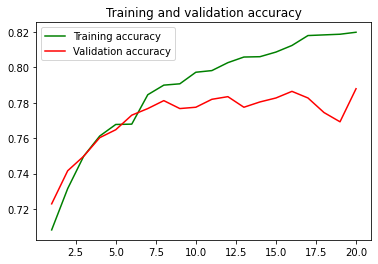

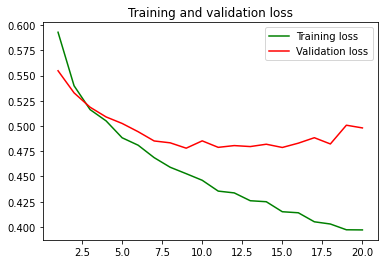

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred1 = (model_glove.predict(X_test_pad) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred1)


array([[885,  82],
       [202, 170]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

0.7879014189693802

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       967
           1       0.67      0.46      0.54       372

    accuracy                           0.79      1339
   macro avg       0.74      0.69      0.70      1339
weighted avg       0.78      0.79      0.77      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred1)

0.5448717948717948

### GloVe Model 2 - Regularized LSTM-ReLu

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_txt = '/content/gdrive/My Drive/243/glove.6B.50d.txt'
f = open(glove_txt, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=8,
                            trainable=False)

In [ ]:
from keras import regularizers
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout

model_glove2 = Sequential()


model_glove2.add(embedding_layer)
model_glove2.add(SpatialDropout1D(0.2))
model_glove2.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model_glove2.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_glove2.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_glove2.add(Dropout(0.2))
model_glove2.add(Dense(1, activation = 'sigmoid'))

model_glove2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

model_glove2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 50)             446100    
                                                                 
 spatial_dropout1d (SpatialD  (None, 8, 50)            0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)               91648     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [ ]:
hist2 = model_glove2.fit(X_train_pad, y_train, batch_size = 64, epochs = 20, callbacks = [checkpoint], validation_data = (X_test_pad, y_test), verbose=1)



Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.7139
Epoch 1: val_accuracy did not improve from 0.78790
84/84 [==============================] - 7s 40ms/step - loss: 0.6282 - accuracy: 0.7138 - val_loss: 0.5871 - val_accuracy: 0.7476
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 0.5846 - accuracy: 0.7361
Epoch 2: val_accuracy did not improve from 0.78790
84/84 [==============================] - 4s 48ms/step - loss: 0.5835 - accuracy: 0.7364 - val_loss: 0.5614 - val_accuracy: 0.7565
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.7444
Epoch 3: val_accuracy did not improve from 0.78790
84/84 [==============================] - 3s 41ms/step - loss: 0.5614 - accuracy: 0.7444 - val_loss: 0.5540 - val_accuracy: 0.7558
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7549
Epoch 4: val_accuracy did not improve from 0.78790
84/84 [=======================

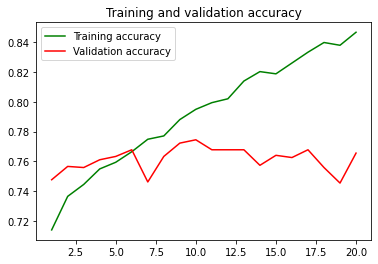

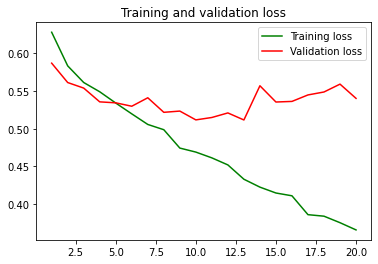

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc2 = hist2.history['accuracy']
val_acc2 = hist2.history['val_accuracy']
loss2 = hist2.history['loss']
val_loss2 = hist2.history['val_loss']

epochs = range(1, len(acc2)+1)

plt.plot(epochs, acc2, 'g', label='Training accuracy')
plt.plot(epochs, val_acc2, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'g', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred2 = (model_glove2.predict(X_test_pad) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred2)


array([[869,  98],
       [216, 156]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred2)

0.765496639283047

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       967
           1       0.61      0.42      0.50       372

    accuracy                           0.77      1339
   macro avg       0.71      0.66      0.67      1339
weighted avg       0.75      0.77      0.75      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred2)

0.4984025559105431

### GloVe Model 3 - Bidirectional LSTM

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_txt = '/content/gdrive/My Drive/243/glove.6B.50d.txt'
f = open(glove_txt, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=8,
                            trainable=False)

In [ ]:
from keras.layers import Bidirectional
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout

model_glove3 = Sequential()


model_glove3.add(embedding_layer)
model_glove3.add(Bidirectional(LSTM(100)))
model_glove3.add(Dropout(0.3))
model_glove3.add(Dense(1, activation = 'sigmoid'))

model_glove3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

model_glove3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 8, 50)             446100    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 567,101
Trainable params: 121,001
Non-trainable params: 446,100
_________________________________________________________________


In [ ]:
hist3 = model_glove3.fit(X_train_pad, y_train, batch_size = 64, epochs = 20, callbacks = [checkpoint], validation_data = (X_test_pad, y_test), verbose=1)



Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 0.5595 - accuracy: 0.7231
Epoch 1: val_accuracy did not improve from 0.78790
84/84 [==============================] - 7s 33ms/step - loss: 0.5597 - accuracy: 0.7228 - val_loss: 0.5300 - val_accuracy: 0.7409
Epoch 2/20
82/84 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.7542
Epoch 2: val_accuracy did not improve from 0.78790
84/84 [==============================] - 2s 23ms/step - loss: 0.5063 - accuracy: 0.7541 - val_loss: 0.5135 - val_accuracy: 0.7550
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7701
Epoch 3: val_accuracy did not improve from 0.78790
84/84 [==============================] - 2s 23ms/step - loss: 0.4858 - accuracy: 0.7701 - val_loss: 0.5065 - val_accuracy: 0.7588
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.7806
Epoch 4: val_accuracy did not improve from 0.78790
84/84 [=======================

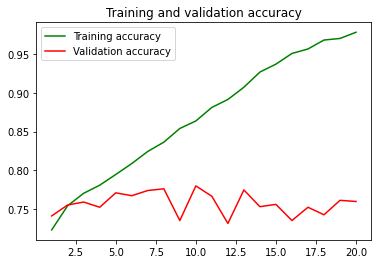

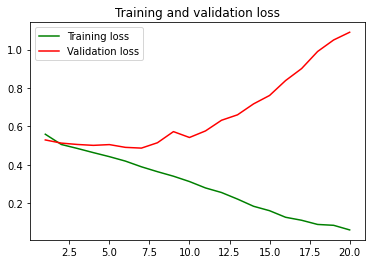

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc3 = hist3.history['accuracy']
val_acc3 = hist3.history['val_accuracy']
loss3 = hist3.history['loss']
val_loss3 = hist3.history['val_loss']

epochs = range(1, len(acc3)+1)

plt.plot(epochs, acc3, 'g', label='Training accuracy')
plt.plot(epochs, val_acc3, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'g', label='Training loss')
plt.plot(epochs, val_loss3, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred3 = (model_glove3.predict(X_test_pad) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred3)


array([[833, 134],
       [188, 184]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred3)

0.7595220313666916

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       967
           1       0.58      0.49      0.53       372

    accuracy                           0.76      1339
   macro avg       0.70      0.68      0.69      1339
weighted avg       0.75      0.76      0.75      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred3)

0.5333333333333333

# Word2Vec Model

In [ ]:
!pip install scikit-learn==0.21.3
!pip install wget==3.2
!pip install gensim==3.6.0
!pip install psutil==5.4.8
!pip install spacy==2.2.4

     |████████████████████████████████| 6.7 MB 3.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c6761158ec45e02a8139c88135c762bb847cc1d298f5904ca1c0f199a9400bb0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import os
import wget
import gzip
import shutil

gn_vec_path = "GoogleNews-vectors-negative300.bin"
if not os.path.exists("GoogleNews-vectors-negative300.bin"):
    if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin"):
        #Downloading the reqired model
        if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin.gz"):
            if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
                wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")
            gn_vec_zip_path = "GoogleNews-vectors-negative300.bin.gz"
        else:
            gn_vec_zip_path = "../Ch2/GoogleNews-vectors-negative300.bin.gz"
        #Extracting the required model
        with gzip.open(gn_vec_zip_path, 'rb') as f_in:
            with open(gn_vec_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        gn_vec_path = "../Ch2/" + gn_vec_path

print(f"Model at {gn_vec_path}")

Model at GoogleNews-vectors-negative300.bin


In [ ]:
import warnings #This module ignores the various types of warnings generated
warnings.filterwarnings("ignore") 

import psutil #This module helps in retrieving information on running processes and system resource utilization
process = psutil.Process(os.getpid())
from psutil import virtual_memory
mem = virtual_memory()

import time #This module is used to calculate the time  

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
pretrainedpath = gn_vec_path

#Load W2V model. This will take some time, but it is a one time effort! 
pre = process.memory_info().rss
print("Memory used in GB before Loading the Model: %0.2f"%float(pre/(10**9))) #Check memory usage before loading the model
print('-'*10)

start_time = time.time() #Start the timer
ttl = mem.total #Toal memory available

w2v_model = KeyedVectors.load_word2vec_format(pretrainedpath, binary=True) #load the model
print("%0.2f seconds taken to load"%float(time.time() - start_time)) #Calculate the total time elapsed since starting the timer
print('-'*10)

print('Finished loading Word2Vec')
print('-'*10)

post = process.memory_info().rss
print("Memory used in GB after Loading the Model: {:.2f}".format(float(post/(10**9)))) #Calculate the memory used after loading the model
print('-'*10)

print("Percentage increase in memory usage: {:.2f}% ".format(float((post/pre)*100))) #Percentage increase in memory after loading the model
print('-'*10)

print("Number of words in vocablulary: ",len(w2v_model.vocab)) #Number of words in the vocabulary. 

Memory used in GB before Loading the Model: 0.79
----------
75.78 seconds taken to load
----------
Finished loading Word2Vec
----------
Memory used in GB after Loading the Model: 5.73
----------
Percentage increase in memory usage: 726.90% 
----------
Numver of words in vocablulary:  3000000


### Word2Vec Model 1 - LSTM

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model: 
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=8,
                            trainable=False)

In [ ]:
model_word2vec = Sequential()
model_word2vec.add(embedding_layer)
model_word2vec.add(LSTM(32,  dropout=0.2, recurrent_dropout=0.25))
model_word2vec.add(Dense(1, activation='sigmoid'))

model_word2vec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 300)            2676600   
                                                                 
 lstm_1 (LSTM)               (None, 32)                42624     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,719,257
Trainable params: 42,657
Non-trainable params: 2,676,600
_________________________________________________________________
None


In [ ]:
hist_word2vec_model = model_word2vec.fit(X_train_pad, y_train, batch_size = 64, epochs = 20, callbacks = [checkpoint], validation_data = (X_test_pad, y_test), verbose=1)


Epoch 1/20
82/84 [============================>.] - ETA: 0s - loss: 0.5967 - accuracy: 0.7073
Epoch 1: val_accuracy did not improve from 0.79985
84/84 [==============================] - 6s 29ms/step - loss: 0.5939 - accuracy: 0.7086 - val_loss: 0.5110 - val_accuracy: 0.7558
Epoch 2/20
82/84 [============================>.] - ETA: 0s - loss: 0.5148 - accuracy: 0.7593
Epoch 2: val_accuracy did not improve from 0.79985
84/84 [==============================] - 2s 25ms/step - loss: 0.5142 - accuracy: 0.7591 - val_loss: 0.4761 - val_accuracy: 0.7789
Epoch 3/20
82/84 [============================>.] - ETA: 0s - loss: 0.4899 - accuracy: 0.7715
Epoch 3: val_accuracy did not improve from 0.79985
84/84 [==============================] - 2s 24ms/step - loss: 0.4885 - accuracy: 0.7724 - val_loss: 0.4682 - val_accuracy: 0.7857
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.7778
Epoch 4: val_accuracy did not improve from 0.79985
84/84 [=======================

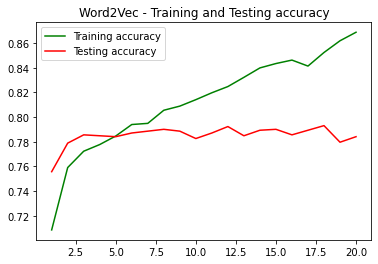

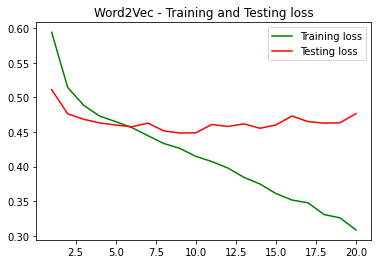

In [ ]:
acc4 = hist_word2vec_model.history['accuracy']
val_acc4 = hist_word2vec_model.history['val_accuracy']
loss4 = hist_word2vec_model.history['loss']
val_loss4 = hist_word2vec_model.history['val_loss']

epochs = range(1, len(acc4)+1)

plt.plot(epochs, acc4, 'g', label='Training accuracy')
plt.plot(epochs, val_acc4, 'r', label='Testing accuracy')
plt.title('Word2Vec - Training and Testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'g', label='Training loss')
plt.plot(epochs, val_loss4, 'r', label='Testing loss')
plt.title('Word2Vec - Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
y_pred21 = (model_word2vec.predict(X_test_pad) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred21)


array([[871,  99],
       [190, 179]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred21)

0.784167289021658

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred21))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       970
           1       0.64      0.49      0.55       369

    accuracy                           0.78      1339
   macro avg       0.73      0.69      0.71      1339
weighted avg       0.77      0.78      0.77      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred21)

0.553323029366306

In [ ]:
model_word2vec.save('/content/gdrive/My Drive/243/model_w2v.h5')

### Word2Vec Model 2 - More layers LSTM

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model: 
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=8,
                            trainable=False)

In [ ]:
model_word2vec2 = Sequential()
model_word2vec2.add(embedding_layer)
model_word2vec2.add(SpatialDropout1D(0.2))
model_word2vec2.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model_word2vec2.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_word2vec2.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_word2vec2.add(Dropout(0.2))
model_word2vec2.add(Dense(1, activation='sigmoid'))

model_word2vec2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 8, 300)            2676600   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 8, 300)           0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)               219648    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
hist_word2vec_model2 = model_word2vec2.fit(X_train_pad, y_train, batch_size = 64, epochs = 20, callbacks = [checkpoint],validation_data = (X_test_pad, y_test), verbose=1)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7209
Epoch 1: val_accuracy did not improve from 0.78790
84/84 [==============================] - 8s 58ms/step - loss: 0.6236 - accuracy: 0.7209 - val_loss: 0.5540 - val_accuracy: 0.7580
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 0.5417 - accuracy: 0.7605
Epoch 2: val_accuracy did not improve from 0.78790
84/84 [==============================] - 4s 53ms/step - loss: 0.5420 - accuracy: 0.7608 - val_loss: 0.5359 - val_accuracy: 0.7730
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7767
Epoch 3: val_accuracy did not improve from 0.78790
84/84 [==============================] - 5s 60ms/step - loss: 0.5145 - accuracy: 0.7767 - val_loss: 0.5244 - val_accuracy: 0.7752
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.7864
Epoch 4: val_accuracy did not improve from 0.78790
84/84 [=======================

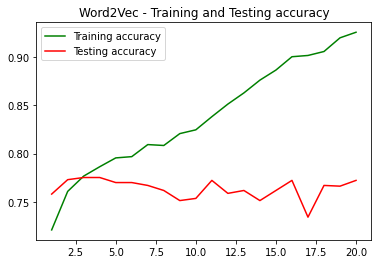

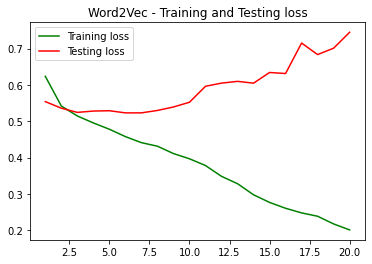

In [ ]:
acc5 = hist_word2vec_model2.history['accuracy']
val_acc5 = hist_word2vec_model2.history['val_accuracy']
loss5 = hist_word2vec_model2.history['loss']
val_loss5 = hist_word2vec_model2.history['val_loss']

epochs = range(1, len(acc4)+1)

plt.plot(epochs, acc5, 'g', label='Training accuracy')
plt.plot(epochs, val_acc5, 'r', label='Testing accuracy')
plt.title('Word2Vec - Training and Testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'g', label='Training loss')
plt.plot(epochs, val_loss5, 'r', label='Testing loss')
plt.title('Word2Vec - Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
y_pred22 = (model_word2vec2.predict(X_test_pad) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred22)


array([[847, 120],
       [185, 187]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred22)

0.772218073188947

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred22))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       967
           1       0.61      0.50      0.55       372

    accuracy                           0.77      1339
   macro avg       0.71      0.69      0.70      1339
weighted avg       0.76      0.77      0.77      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred22)

0.5508100147275405

### Word2Vec Model 3 - Bidirectional LSTM

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model: 
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=8,
                            trainable=False)

In [ ]:
model_word2vec3 = Sequential()
model_word2vec3.add(embedding_layer)
model_word2vec3.add(Bidirectional(LSTM(100)))
model_word2vec3.add(Dropout(0.3))
model_word2vec3.add(Dense(1, activation='sigmoid'))

model_word2vec3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec3.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 8, 300)            2676600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,997,601
Trainable params: 321,001
Non-trainable params: 2,676,600
_________________________________________________________________
None


In [ ]:
hist_word2vec_model3 = model_word2vec3.fit(X_train_pad, y_train, batch_size = 64, epochs = 20, callbacks = [checkpoint],validation_data = (X_test_pad, y_test), verbose=1)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7371
Epoch 1: val_accuracy did not improve from 0.78790
84/84 [==============================] - 10s 58ms/step - loss: 0.5472 - accuracy: 0.7371 - val_loss: 0.5061 - val_accuracy: 0.7685
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.7812
Epoch 2: val_accuracy did not improve from 0.78790
84/84 [==============================] - 4s 43ms/step - loss: 0.4725 - accuracy: 0.7812 - val_loss: 0.4920 - val_accuracy: 0.7789
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8000
Epoch 3: val_accuracy did not improve from 0.78790
84/84 [==============================] - 3s 41ms/step - loss: 0.4446 - accuracy: 0.8000 - val_loss: 0.5097 - val_accuracy: 0.7655
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8078
Epoch 4: val_accuracy did not improve from 0.78790
84/84 [======================

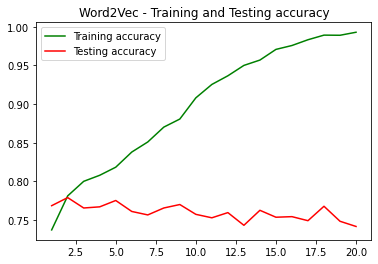

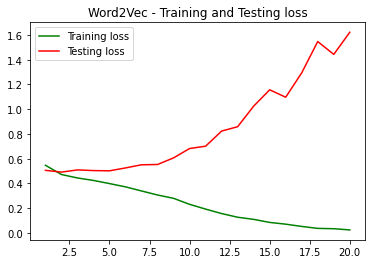

In [ ]:
acc6 = hist_word2vec_model3.history['accuracy']
val_acc6 = hist_word2vec_model3.history['val_accuracy']
loss6 = hist_word2vec_model3.history['loss']
val_loss6 = hist_word2vec_model3.history['val_loss']

epochs = range(1, len(acc6)+1)

plt.plot(epochs, acc6, 'g', label='Training accuracy')
plt.plot(epochs, val_acc6, 'r', label='Testing accuracy')
plt.title('Word2Vec - Training and Testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss6, 'g', label='Training loss')
plt.plot(epochs, val_loss6, 'r', label='Testing loss')
plt.title('Word2Vec - Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
y_pred23 = (model_word2vec3.predict(X_test_pad) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred23)


array([[765, 202],
       [144, 228]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred23)

0.7415982076176251

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred23))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       967
           1       0.53      0.61      0.57       372

    accuracy                           0.74      1339
   macro avg       0.69      0.70      0.69      1339
weighted avg       0.76      0.74      0.75      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred23)

0.5685785536159601

# Data Cleaning for NLP - bodies

In [ ]:
body_train = list()
bodies = df_train['body'].values.tolist()

for body in bodies:
    # tokenize the text
    tokens = word_tokenize(body)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    body_train.append(lemma)
    
body_train[0:5]

[['kate',
  'middleton',
  'want',
  'kid',
  'know',
  'ok',
  'talk',
  'mental',
  'health',
  'duchess',
  'cambridge',
  'soontobe',
  'mother',
  'three',
  'provided',
  'brief',
  'introduction',
  'new',
  'short',
  'child',
  'film',
  'subject',
  'titled',
  'talking',
  'mental',
  'health',
  'mental',
  'health',
  'feel',
  'think',
  'middleton',
  'say',
  'intro',
  'thing',
  'ca',
  'nt',
  'really',
  'seen',
  'affect',
  'u',
  'every',
  'day',
  'talking',
  'feel',
  'difficult',
  'animated',
  'film',
  'created',
  'anna',
  'freud',
  'national',
  'centre',
  'child',
  'family',
  'ukbased',
  'mental',
  'health',
  'charity',
  'focused',
  'child',
  'care',
  'video',
  'help',
  'u',
  'talk',
  'mental',
  'health',
  'say',
  'talk',
  'feeling',
  'big',
  'manage',
  'middleton',
  'say',
  'film',
  'kid',
  'depicted',
  'doodled',
  'thumbprint',
  'introduce',
  'concept',
  'small',
  'feeling',
  'fleeting',
  'positive',
  'negative',
 

In [ ]:
validation_split = 0.2
max_length = 110

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(body_train)
sequences = tokenizer_obj.texts_to_sequences(body_train)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  df_train['fake_news'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

#n_values = np.max(category) + 1
#Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad_b = lines_pad[:-num_validation_samples]
y_train_b = category[:-num_validation_samples]
X_test_pad_b = lines_pad[-num_validation_samples:]
y_test_b = category[-num_validation_samples:]

unique tokens - 64301
vocab_size - 64302


In [ ]:
print('Shape of X_train_pad_b:', X_train_pad_b.shape)
print('Shape of y_train_b:', y_train_b.shape)

print('Shape of X_test_pad_b:', X_test_pad_b.shape)
print('Shape of y_test_b:', y_test_b.shape)

Shape of X_train_pad_b: (5360, 110)
Shape of y_train_b: (5360,)
Shape of X_test_pad_b: (1339, 110)
Shape of y_test_b: (1339,)


# GloVe Models

### GloVe Model 1 - LSTM

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_txt = '/content/gdrive/My Drive/243/glove.6B.50d.txt'
f = open(glove_txt, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=110,
                            trainable=False)

In [ ]:
model_glove_b = Sequential()
model_glove_b.add(embedding_layer)
model_glove_b.add(LSTM(32,  dropout=0.2, recurrent_dropout=0.25))
model_glove_b.add(Dense(1, activation='sigmoid'))

model_glove_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_glove_b.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 110, 50)           3215100   
                                                                 
 lstm_9 (LSTM)               (None, 32)                10624     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,225,757
Trainable params: 10,657
Non-trainable params: 3,215,100
_________________________________________________________________
None


In [ ]:
hist = model_glove_b.fit(X_train_pad_b, y_train_b, batch_size = 64, epochs = 20, callbacks = [checkpoint] ,validation_data = (X_test_pad_b, y_test_b), verbose=1)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.7142
Epoch 1: val_accuracy did not improve from 0.81105
84/84 [==============================] - 20s 150ms/step - loss: 0.5970 - accuracy: 0.7142 - val_loss: 0.5871 - val_accuracy: 0.7080
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.7155
Epoch 2: val_accuracy did not improve from 0.81105
84/84 [==============================] - 13s 154ms/step - loss: 0.5815 - accuracy: 0.7155 - val_loss: 0.5793 - val_accuracy: 0.7065
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.7220
Epoch 3: val_accuracy did not improve from 0.81105
84/84 [==============================] - 12s 145ms/step - loss: 0.5612 - accuracy: 0.7220 - val_loss: 0.5639 - val_accuracy: 0.7409
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.5648 - accuracy: 0.7132
Epoch 4: val_accuracy did not improve from 0.81105
84/84 [=================

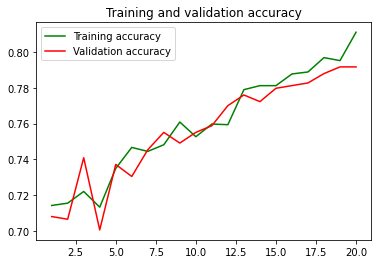

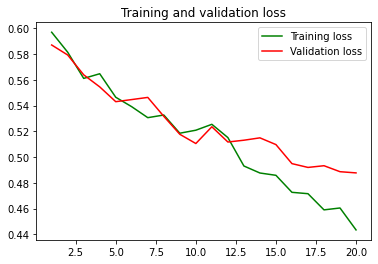

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred31 = (model_glove_b.predict(X_test_pad_b) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_b,y_pred31)


array([[858,  90],
       [189, 202]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_b,y_pred31)

0.7916355489171023

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_b,y_pred31))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       948
           1       0.69      0.52      0.59       391

    accuracy                           0.79      1339
   macro avg       0.76      0.71      0.73      1339
weighted avg       0.78      0.79      0.78      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_b, y_pred31)

0.5915080527086383

### GloVe Model 2 - Regularized LSTM + ReLu

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_txt = '/content/gdrive/My Drive/243/glove.6B.50d.txt'
f = open(glove_txt, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=110,
                            trainable=False)

In [ ]:
from keras import regularizers
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout

model_glove2 = Sequential()


model_glove2.add(embedding_layer)
model_glove2.add(SpatialDropout1D(0.2))
model_glove2.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model_glove2.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_glove2.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_glove2.add(Dropout(0.2))
model_glove2.add(Dense(1, activation = 'sigmoid'))

model_glove2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

model_glove2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 110, 50)           3215100   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 110, 50)          0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 128)               91648     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
hist2 = model_glove2.fit(X_train_pad_b, y_train_b, batch_size = 64, epochs = 20, callbacks = [checkpoint] ,validation_data = (X_test_pad_b, y_test_b), verbose=1)



Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.7425
Epoch 1: val_accuracy did not improve from 0.79164
84/84 [==============================] - 38s 456ms/step - loss: 0.5322 - accuracy: 0.7425 - val_loss: 0.5519 - val_accuracy: 0.7364
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7526
Epoch 2: val_accuracy did not improve from 0.79164
84/84 [==============================] - 30s 360ms/step - loss: 0.5227 - accuracy: 0.7526 - val_loss: 0.5142 - val_accuracy: 0.7834
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7550
Epoch 3: val_accuracy did not improve from 0.79164
84/84 [==============================] - 30s 360ms/step - loss: 0.5059 - accuracy: 0.7550 - val_loss: 0.5455 - val_accuracy: 0.7610
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.7692
Epoch 4: val_accuracy did not improve from 0.79164
84/84 [=================

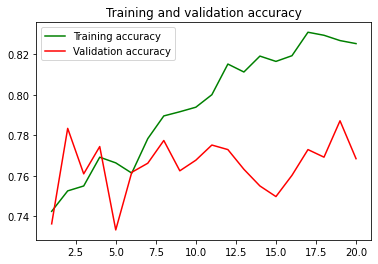

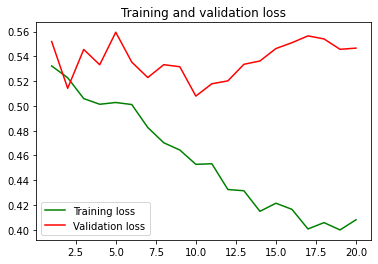

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc2 = hist2.history['accuracy']
val_acc2 = hist2.history['val_accuracy']
loss2 = hist2.history['loss']
val_loss2 = hist2.history['val_loss']

epochs = range(1, len(acc2)+1)

plt.plot(epochs, acc2, 'g', label='Training accuracy')
plt.plot(epochs, val_acc2, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'g', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred32 = (model_glove2.predict(X_test_pad_b) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_b,y_pred32)


array([[845, 115],
       [195, 184]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_b,y_pred32)

0.7684839432412248

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_b,y_pred32))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       960
           1       0.62      0.49      0.54       379

    accuracy                           0.77      1339
   macro avg       0.71      0.68      0.69      1339
weighted avg       0.76      0.77      0.76      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_b, y_pred32)

0.5427728613569321

### GloVe Model 3 - Bidirectional LSTM

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_txt = '/content/gdrive/My Drive/243/glove.6B.50d.txt'
f = open(glove_txt, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=110,
                            trainable=False)

In [ ]:
from keras.layers import Bidirectional

model_glove3 = Sequential()


model_glove3.add(embedding_layer)
model_glove3.add(Bidirectional(LSTM(100)))
model_glove3.add(Dropout(0.3))
model_glove3.add(Dense(1, activation = 'sigmoid'))

model_glove3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

model_glove3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 110, 50)           3215100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              120800    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,336,101
Trainable params: 121,001
Non-trainable params: 3,215,100
_________________________________________________________________


In [ ]:
hist3 = model_glove3.fit(X_train_pad_b, y_train_b, batch_size = 64, epochs = 20, callbacks =[checkpoint], validation_data = (X_test_pad_b, y_test_b), verbose=1)


Epoch 1/20
84/84 [==============================] - 38s 401ms/step - loss: 0.5677 - accuracy: 0.7201 - val_loss: 0.5287 - val_accuracy: 0.7326
Epoch 2/20
84/84 [==============================] - 32s 379ms/step - loss: 0.5130 - accuracy: 0.7547 - val_loss: 0.5217 - val_accuracy: 0.7513
Epoch 3/20
84/84 [==============================] - 34s 400ms/step - loss: 0.4943 - accuracy: 0.7729 - val_loss: 0.4980 - val_accuracy: 0.7633
Epoch 4/20
84/84 [==============================] - 33s 394ms/step - loss: 0.4715 - accuracy: 0.7826 - val_loss: 0.4972 - val_accuracy: 0.7662
Epoch 5/20
84/84 [==============================] - 33s 392ms/step - loss: 0.4528 - accuracy: 0.8039 - val_loss: 0.4943 - val_accuracy: 0.7789
Epoch 6/20
84/84 [==============================] - 31s 366ms/step - loss: 0.4372 - accuracy: 0.8058 - val_loss: 0.4917 - val_accuracy: 0.7767
Epoch 7/20
84/84 [==============================] - 30s 363ms/step - loss: 0.4149 - accuracy: 0.8250 - val_loss: 0.4973 - val_accuracy: 0.7745

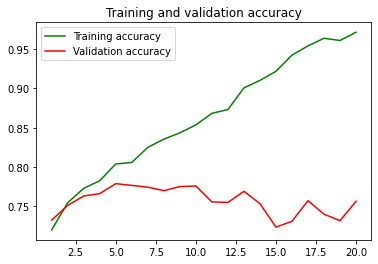

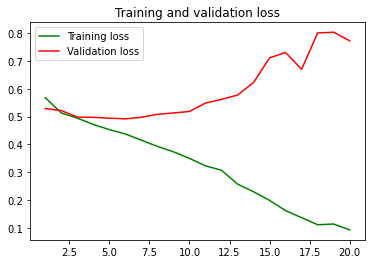

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc3 = hist3.history['accuracy']
val_acc3 = hist3.history['val_accuracy']
loss3 = hist3.history['loss']
val_loss3 = hist3.history['val_loss']

epochs = range(1, len(acc3)+1)

plt.plot(epochs, acc3, 'g', label='Training accuracy')
plt.plot(epochs, val_acc3, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'g', label='Training loss')
plt.plot(epochs, val_loss3, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred33 = (model_glove3.predict(X_test_pad_b) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_b,y_pred33)


array([[820, 140],
       [186, 193]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_b,y_pred33)

0.7565347274085138

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_b,y_pred33))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       960
           1       0.58      0.51      0.54       379

    accuracy                           0.76      1339
   macro avg       0.70      0.68      0.69      1339
weighted avg       0.75      0.76      0.75      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_b, y_pred33)

0.5421348314606741

# Word2Vec Model

### Word2Vec Model 1 - LSTM

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model: 
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=110,
                            trainable=False)

In [ ]:
model_word2vec_b = Sequential()
model_word2vec_b.add(embedding_layer)
model_word2vec_b.add(LSTM(32,  dropout=0.2, recurrent_dropout=0.25))
model_word2vec_b.add(Dense(1, activation='sigmoid'))

model_word2vec_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec_b.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 110, 300)          19290600  
                                                                 
 lstm_2 (LSTM)               (None, 32)                42624     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,333,257
Trainable params: 42,657
Non-trainable params: 19,290,600
_________________________________________________________________
None


In [ ]:
hist_word2vec_model_b = model_word2vec_b.fit(X_train_pad_b, y_train_b, batch_size = 64, epochs = 20, callbacks =[checkpoint], validation_data = (X_test_pad_b, y_test_b), verbose=1)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7095
Epoch 1: val_accuracy did not improve from 0.79985
84/84 [==============================] - 30s 319ms/step - loss: 0.5981 - accuracy: 0.7095 - val_loss: 0.5712 - val_accuracy: 0.7237
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7203
Epoch 2: val_accuracy did not improve from 0.79985
84/84 [==============================] - 24s 284ms/step - loss: 0.5547 - accuracy: 0.7203 - val_loss: 0.5102 - val_accuracy: 0.7476
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7644
Epoch 3: val_accuracy did not improve from 0.79985
84/84 [==============================] - 24s 285ms/step - loss: 0.5160 - accuracy: 0.7644 - val_loss: 0.5396 - val_accuracy: 0.7521
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.4970 - accuracy: 0.7784
Epoch 4: val_accuracy did not improve from 0.79985
84/84 [=================

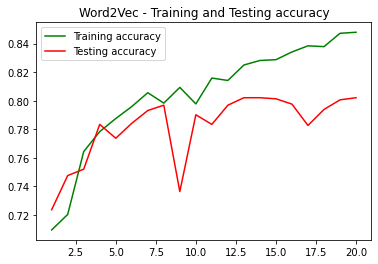

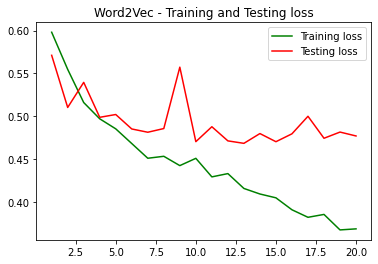

In [ ]:
acc4 = hist_word2vec_model_b.history['accuracy']
val_acc4 = hist_word2vec_model_b.history['val_accuracy']
loss4 = hist_word2vec_model_b.history['loss']
val_loss4 = hist_word2vec_model_b.history['val_loss']

epochs = range(1, len(acc4)+1)

plt.plot(epochs, acc4, 'g', label='Training accuracy')
plt.plot(epochs, val_acc4, 'r', label='Testing accuracy')
plt.title('Word2Vec - Training and Testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'g', label='Training loss')
plt.plot(epochs, val_loss4, 'r', label='Testing loss')
plt.title('Word2Vec - Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
y_pred41 = (model_word2vec_b.predict(X_test_pad_b) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_b,y_pred41)


array([[896,  71],
       [194, 178]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_b,y_pred41)

0.8020911127707244

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_b,y_pred41))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       967
           1       0.71      0.48      0.57       372

    accuracy                           0.80      1339
   macro avg       0.77      0.70      0.72      1339
weighted avg       0.79      0.80      0.79      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_b, y_pred41)

0.573268921095008

In [ ]:
model_word2vec_b.save('/content/gdrive/My Drive/243/model_w2v_b.h5')

### Word2Vec Model 2 - Regularized LSTM + ReLu

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model: 
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=110,
                            trainable=False)

In [ ]:
model_word2vec2_b = Sequential()
model_word2vec2_b.add(embedding_layer)
model_word2vec2_b.add(SpatialDropout1D(0.2))
model_word2vec2_b.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model_word2vec2_b.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_word2vec2_b.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model_word2vec2_b.add(Dropout(0.2))
model_word2vec2_b.add(Dense(1, activation='sigmoid'))

model_word2vec2_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec2_b.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 110, 300)          19290600  
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 110, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_14 (LSTM)              (None, 128)               219648    
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                     

In [ ]:
hist_word2vec_model2_b = model_word2vec2_b.fit(X_train_pad_b, y_train_b, batch_size = 64, epochs = 20, callbacks =[checkpoint], validation_data = (X_test_pad_b, y_test_b), verbose=1)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7091
Epoch 1: val_accuracy did not improve from 0.80358
84/84 [==============================] - 77s 876ms/step - loss: 0.6435 - accuracy: 0.7091 - val_loss: 0.6065 - val_accuracy: 0.7170
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7552
Epoch 2: val_accuracy did not improve from 0.80358
84/84 [==============================] - 51s 608ms/step - loss: 0.5668 - accuracy: 0.7552 - val_loss: 0.5375 - val_accuracy: 0.7767
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7507
Epoch 3: val_accuracy did not improve from 0.80358
84/84 [==============================] - 51s 604ms/step - loss: 0.5559 - accuracy: 0.7507 - val_loss: 0.5846 - val_accuracy: 0.7311
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.7741
Epoch 4: val_accuracy did not improve from 0.80358
84/84 [=================

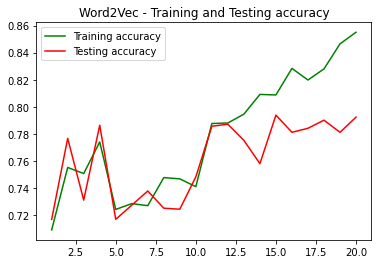

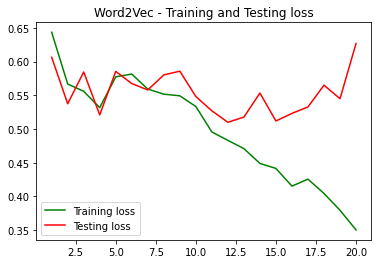

In [ ]:
acc5 = hist_word2vec_model2_b.history['accuracy']
val_acc5 = hist_word2vec_model2_b.history['val_accuracy']
loss5 = hist_word2vec_model2_b.history['loss']
val_loss5 = hist_word2vec_model2_b.history['val_loss']

epochs = range(1, len(acc4)+1)

plt.plot(epochs, acc5, 'g', label='Training accuracy')
plt.plot(epochs, val_acc5, 'r', label='Testing accuracy')
plt.title('Word2Vec - Training and Testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'g', label='Training loss')
plt.plot(epochs, val_loss5, 'r', label='Testing loss')
plt.title('Word2Vec - Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
y_pred42 = (model_word2vec2_b.predict(X_test_pad_b) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_b,y_pred42)


array([[895,  65],
       [213, 166]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_b,y_pred42)

0.7923823749066468

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_b,y_pred42))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       960
           1       0.72      0.44      0.54       379

    accuracy                           0.79      1339
   macro avg       0.76      0.69      0.70      1339
weighted avg       0.78      0.79      0.77      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_b, y_pred42)

0.5442622950819671

### Word2Vec Model 3 - Bidirectional LSTM

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model: 
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=110,
                            trainable=False)

In [ ]:
model_word2vec3_b = Sequential()
model_word2vec3_b.add(embedding_layer)
model_word2vec3_b.add(Bidirectional(LSTM(100)))
model_word2vec3_b.add(Dropout(0.3))
model_word2vec3_b.add(Dense(1, activation='sigmoid'))

model_word2vec3_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec3_b.summary())


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 110, 300)          19290600  
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 201       
                                                                 
Total params: 19,611,601
Trainable params: 321,001
Non-trainable params: 19,290,600
_________________________________________________________________
None


In [ ]:
hist_word2vec_model3_b = model_word2vec3_b.fit(X_train_pad_b, y_train_b, batch_size = 64, epochs = 20,callbacks =[checkpoint], validation_data = (X_test_pad_b, y_test_b), verbose=1)


Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7362
Epoch 1: val_accuracy did not improve from 0.80358
84/84 [==============================] - 44s 470ms/step - loss: 0.5560 - accuracy: 0.7362 - val_loss: 0.5023 - val_accuracy: 0.7819
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.7821
Epoch 2: val_accuracy did not improve from 0.80358
84/84 [==============================] - 39s 466ms/step - loss: 0.4855 - accuracy: 0.7821 - val_loss: 0.4997 - val_accuracy: 0.7722
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.7944
Epoch 3: val_accuracy did not improve from 0.80358
84/84 [==============================] - 39s 464ms/step - loss: 0.4698 - accuracy: 0.7944 - val_loss: 0.4730 - val_accuracy: 0.7946
Epoch 4/20
84/84 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.8026
Epoch 4: val_accuracy did not improve from 0.80358
84/84 [=================

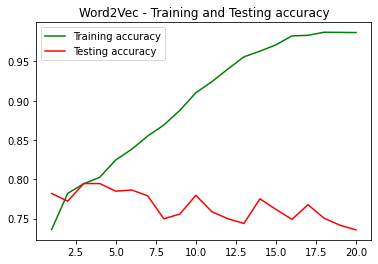

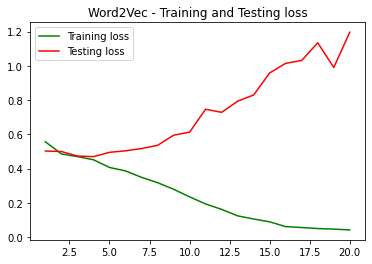

In [ ]:
acc6 = hist_word2vec_model3_b.history['accuracy']
val_acc6 = hist_word2vec_model3_b.history['val_accuracy']
loss6 = hist_word2vec_model3_b.history['loss']
val_loss6 = hist_word2vec_model3_b.history['val_loss']

epochs = range(1, len(acc6)+1)

plt.plot(epochs, acc6, 'g', label='Training accuracy')
plt.plot(epochs, val_acc6, 'r', label='Testing accuracy')
plt.title('Word2Vec - Training and Testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss6, 'g', label='Training loss')
plt.plot(epochs, val_loss6, 'r', label='Testing loss')
plt.title('Word2Vec - Training and Testing loss')
plt.legend()

plt.show()

In [ ]:
y_pred43 = (model_word2vec3_b.predict(X_test_pad_b) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_b,y_pred43)


array([[782, 178],
       [176, 203]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_b,y_pred43)

0.7356235997012696

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_b,y_pred43))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       960
           1       0.53      0.54      0.53       379

    accuracy                           0.74      1339
   macro avg       0.67      0.68      0.67      1339
weighted avg       0.74      0.74      0.74      1339



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_b, y_pred43)

0.5342105263157895

In [ ]:
 model_glove_b.save('/content/gdrive/My Drive/243/model_glove_b.h5')


# Prediction from LSTM using textual features

### Data preprocessing - title_train

In [ ]:
title_train = list()
titles = df_train['title'].values.tolist()

for title in titles:
    # tokenize the text
    tokens = word_tokenize(title)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    title_train.append(lemma)
    
title_train[0:5]

[['kate',
  'middleton',
  'introduces',
  'mental',
  'health',
  'film',
  'paying',
  'attention',
  'small',
  'feeling'],
 ['topless',
  'activist',
  'crash',
  'woody',
  'allen',
  'concert',
  'germany',
  'protest',
  'sexual',
  'violence'],
 ['jax',
  'taylor',
  'brittany',
  'cartwright',
  'lala',
  'kent',
  'slam',
  'james',
  'kennedy'],
 ['jon',
  'hamm',
  'slam',
  'social',
  'medium',
  'visual',
  'equivalent',
  'masturbating'],
 ['bachelor',
  'star',
  'nick',
  'viall',
  'vanessa',
  'grimaldi',
  'speak',
  'split']]

In [ ]:
max_length = 8

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(title_train)
sequences = tokenizer_obj.texts_to_sequences(title_train)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

X_train_t = pad_sequences(sequences, maxlen=max_length, padding='post')
y_train_t =  df_train['fake_news'].values


unique tokens - 8921
vocab_size - 8922


### Data preprocessing - title_val

In [ ]:
title_val = list()
titles = df_val['title'].values.tolist()

for title in titles:
    # tokenize the text
    tokens = word_tokenize(title)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    title_val.append(lemma)
    
title_val[0:5]

[['democratic', 'debate', 'cleveland'],
 ['miley',
  'cyrus',
  'celebrates',
  'birthday',
  'family',
  'losing',
  'home',
  'fire'],
 ['brad',
  'pitt',
  'jennifer',
  'aniston',
  'rekindle',
  'romance',
  'despite',
  'justin',
  'theroux',
  'love',
  'duo',
  'caught',
  'kissing',
  'rumor'],
 ['u',
  'cast',
  'share',
  'hopefully',
  'fake',
  'spoiler',
  'season',
  'red',
  'nose',
  'day'],
 ['audrina',
  'patridge',
  'ryan',
  'cabrera',
  'attend',
  'stagecoach',
  'together']]

In [ ]:
max_length = 8

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(title_val)
sequences = tokenizer_obj.texts_to_sequences(title_val)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

X_val_t = pad_sequences(sequences, maxlen=max_length, padding='post')
y_val_t =  df_val['fake_news'].values


unique tokens - 3302
vocab_size - 3303


### Data preprocessing - title_test

In [ ]:
title_test = list()
titles = df_test['title'].values.tolist()

for title in titles:
    # tokenize the text
    tokens = word_tokenize(title)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    title_test.append(lemma)
    
title_test[0:5]

[['makeup', 'artist', 'accuses', 'ben', 'affleck', 'groping'],
 ['saturday',
  'night',
  'live',
  'finally',
  'tackle',
  'harvey',
  'weinstein',
  'scandal',
  'harassment',
  'hollywood'],
 ['family',
  'say',
  'jetblue',
  'kicked',
  'flight',
  'argument',
  'birthday',
  'cake'],
 ['celebrity', 'treat', 'significant', 'others', 'like', 'trash'],
 ['air',
  'force',
  'veteran',
  'granted',
  'dying',
  'wish',
  'see',
  'last',
  'jedi']]

In [ ]:
max_length = 8

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(title_test)
sequences = tokenizer_obj.texts_to_sequences(title_test)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

X_test_t = pad_sequences(sequences, maxlen=max_length, padding='post')
y_test_t =  df_test['fake_news'].values


unique tokens - 5520
vocab_size - 5521


### Data preprocessing - body_train

In [ ]:
body_train = list()
bodies = df_train['body'].values.tolist()

for body in bodies:
    # tokenize the text
    tokens = word_tokenize(body)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    body_train.append(lemma)
    
body_train[0:5]

[['kate',
  'middleton',
  'want',
  'kid',
  'know',
  'ok',
  'talk',
  'mental',
  'health',
  'duchess',
  'cambridge',
  'soontobe',
  'mother',
  'three',
  'provided',
  'brief',
  'introduction',
  'new',
  'short',
  'child',
  'film',
  'subject',
  'titled',
  'talking',
  'mental',
  'health',
  'mental',
  'health',
  'feel',
  'think',
  'middleton',
  'say',
  'intro',
  'thing',
  'ca',
  'nt',
  'really',
  'seen',
  'affect',
  'u',
  'every',
  'day',
  'talking',
  'feel',
  'difficult',
  'animated',
  'film',
  'created',
  'anna',
  'freud',
  'national',
  'centre',
  'child',
  'family',
  'ukbased',
  'mental',
  'health',
  'charity',
  'focused',
  'child',
  'care',
  'video',
  'help',
  'u',
  'talk',
  'mental',
  'health',
  'say',
  'talk',
  'feeling',
  'big',
  'manage',
  'middleton',
  'say',
  'film',
  'kid',
  'depicted',
  'doodled',
  'thumbprint',
  'introduce',
  'concept',
  'small',
  'feeling',
  'fleeting',
  'positive',
  'negative',
 

In [ ]:
max_length = 110

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(body_train)
sequences = tokenizer_obj.texts_to_sequences(body_train)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

X_train_b = pad_sequences(sequences, maxlen=max_length, padding='post')
y_train_b =  df_train['fake_news'].values


unique tokens - 64301
vocab_size - 64302


### Data preprocessing - body_val

In [ ]:
body_val = list()
bodies = df_val['body'].values.tolist()

for body in bodies:
    # tokenize the text
    tokens = word_tokenize(body)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    body_val.append(lemma)
    
body_val[0:5]

[['rightly',
  'big',
  'issue',
  'ohio',
  'laid',
  'criticism',
  'addition',
  'plan',
  'actually',
  'fixing',
  'nafta',
  'received',
  'lot',
  'incoming',
  'criticism',
  'senator',
  'obama',
  'cleveland',
  'plain',
  'dealer',
  'examined',
  'senator',
  'obama',
  'attack',
  'regarding',
  'nafta',
  'said',
  'erroneous',
  'would',
  'hope',
  'get',
  'debate',
  'real',
  'issue',
  'stand',
  'need',
  'fix',
  'nafta',
  'working',
  'unfortunately',
  'heavily',
  'disadvantaging',
  'many',
  'industry',
  'particularly',
  'manufacturing',
  'record',
  'standing',
  'chairing',
  'manufacturing',
  'caucus',
  'senate',
  'take',
  'tough',
  'position',
  'trade',
  'agreement',
  'mr',
  'williams',
  'senator',
  'thank',
  'turn',
  'questioning',
  'tim',
  'russert',
  'senator',
  'obama',
  'sen',
  'obama',
  'well',
  'think',
  'inaccurate',
  'senator',
  'clinton',
  'say',
  'always',
  'opposed',
  'nafta',
  'campaign',
  'senate',
  'said',

In [ ]:
max_length = 110

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(body_val)
sequences = tokenizer_obj.texts_to_sequences(body_val)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

X_val_b = pad_sequences(sequences, maxlen=max_length, padding='post')
y_val_b =  df_val['fake_news'].values


unique tokens - 24557
vocab_size - 24558


### Data preprocessing - body_test

In [ ]:
body_test = list()
bodies = df_test['body'].values.tolist()

for body in bodies:
    # tokenize the text
    tokens = word_tokenize(body)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    alpha = [s for s in stripped if s.isalpha()]
    # remove stopwords
    words = [word for word in alpha if not word in stop_words]
    # lemmatized
    lemma = [wordnet.lemmatize(word) for word in words]
    body_test.append(lemma)
    
body_val[0:5]

[['rightly',
  'big',
  'issue',
  'ohio',
  'laid',
  'criticism',
  'addition',
  'plan',
  'actually',
  'fixing',
  'nafta',
  'received',
  'lot',
  'incoming',
  'criticism',
  'senator',
  'obama',
  'cleveland',
  'plain',
  'dealer',
  'examined',
  'senator',
  'obama',
  'attack',
  'regarding',
  'nafta',
  'said',
  'erroneous',
  'would',
  'hope',
  'get',
  'debate',
  'real',
  'issue',
  'stand',
  'need',
  'fix',
  'nafta',
  'working',
  'unfortunately',
  'heavily',
  'disadvantaging',
  'many',
  'industry',
  'particularly',
  'manufacturing',
  'record',
  'standing',
  'chairing',
  'manufacturing',
  'caucus',
  'senate',
  'take',
  'tough',
  'position',
  'trade',
  'agreement',
  'mr',
  'williams',
  'senator',
  'thank',
  'turn',
  'questioning',
  'tim',
  'russert',
  'senator',
  'obama',
  'sen',
  'obama',
  'well',
  'think',
  'inaccurate',
  'senator',
  'clinton',
  'say',
  'always',
  'opposed',
  'nafta',
  'campaign',
  'senate',
  'said',

In [ ]:
max_length = 110

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(body_test)
sequences = tokenizer_obj.texts_to_sequences(body_test)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

X_test_b = pad_sequences(sequences, maxlen=max_length, padding='post')
y_test_b =  df_test['fake_news'].values


unique tokens - 41660
vocab_size - 41661


### Prediction of NLP models for both new titles and bodeis

In [ ]:
print('Shape of X_train_t:', X_train_t.shape)
print('Shape of y_train:', y_train_t.shape)
print('Shape of X_val_t:', X_val_t.shape)
print('Shape of y_val_t:', y_val_t.shape)
print('Shape of X_test_t:', X_test_t.shape)
print('Shape of y_test_t:', y_test_t.shape)

Shape of X_train_t: (6699, 8)
Shape of y_train: (6699,)
Shape of X_val_t: (1002, 8)
Shape of y_val_t: (1002,)
Shape of X_test_t: (2567, 8)
Shape of y_test_t: (2567,)


In [ ]:
from keras.models import load_model
model_glove_t = load_model('/content/gdrive/My Drive/243/model_glove.h5')
model_w2v_t = load_model('/content/gdrive/My Drive/243/model_w2v.h5')


In [ ]:
ypred_train_t_prob = model_glove_t.predict(X_train_t, batch_size=32, verbose=1)
ypred_train_t_class = (model_glove_t.predict(X_train_t, batch_size=32, verbose=1)>0.5).astype(int)
ypred_val_t_prob = model_glove_t.predict(X_val_t, batch_size=32, verbose=1)
ypred_val_t_class = (model_glove_t.predict(X_val_t, batch_size=32, verbose=1)>0.5).astype(int)
ypred_test_t_prob = model_glove_t.predict(X_test_t, batch_size=32, verbose=1)
ypred_test_t_class = (model_glove_t.predict(X_test_t, batch_size=32, verbose=1)>0.5).astype(int)

81/81 [==============================] - 0s 4ms/step


In [ ]:
df1 = pd.DataFrame(ypred_train_t_prob, columns = ['fake_title_prob'])
df2 = pd.DataFrame(ypred_train_t_class, columns = ['fake_title_class'])
df3 = pd.DataFrame(ypred_val_t_prob, columns = ['fake_title_prob'])
df4 = pd.DataFrame(ypred_val_t_class, columns = ['fake_title_class'])
df5 = pd.DataFrame(ypred_test_t_prob, columns = ['fake_title_prob'])
df6 = pd.DataFrame(ypred_test_t_class, columns = ['fake_title_class'])


In [ ]:
df1.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_t_prob.csv")
df2.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_t_class.csv")
df3.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_t_prob.csv")
df4.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_t_class.csv")
df5.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_t_prob.csv")
df6.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_t_class.csv")

In [ ]:
print('Shape of X_train_b:', X_train_b.shape)
print('Shape of y_train_b:', y_train_b.shape)
print('Shape of X_val_b:', X_val_b.shape)
print('Shape of y_val_b:', y_val_b.shape)
print('Shape of X_test_b:', X_test_b.shape)
print('Shape of y_test_b:', y_test_b.shape)

Shape of X_train_b: (6699, 110)
Shape of y_train_b: (6699,)
Shape of X_val_b: (1002, 110)
Shape of y_val_b: (1002,)
Shape of X_test_b: (2567, 110)
Shape of y_test_b: (2567,)


In [ ]:
ypred_train_t_prob_w2v = model_w2v_t.predict(X_train_t, batch_size=32, verbose=1)
ypred_train_t_class_w2v = (model_w2v_t.predict(X_train_t, batch_size=32, verbose=1)>0.5).astype(int)
ypred_val_t_prob_w2v = model_w2v_t.predict(X_val_t, batch_size=32, verbose=1)
ypred_val_t_class_w2v = (model_w2v_t.predict(X_val_t, batch_size=32, verbose=1)>0.5).astype(int)
ypred_test_t_prob_w2v = model_w2v_t.predict(X_test_t, batch_size=32, verbose=1)
ypred_test_t_class_w2v = (model_w2v_t.predict(X_test_t, batch_size=32, verbose=1)>0.5).astype(int)

81/81 [==============================] - 0s 4ms/step


In [ ]:
dfw1 = pd.DataFrame(ypred_train_t_prob_w2v, columns = ['fake_title_prob'])
dfw2 = pd.DataFrame(ypred_train_t_class_w2v, columns = ['fake_title_class'])
dfw3 = pd.DataFrame(ypred_val_t_prob_w2v, columns = ['fake_title_prob'])
dfw4 = pd.DataFrame(ypred_val_t_class_w2v, columns = ['fake_title_class'])
dfw5 = pd.DataFrame(ypred_test_t_prob_w2v, columns = ['fake_title_prob'])
dfw6 = pd.DataFrame(ypred_test_t_class_w2v, columns = ['fake_title_class'])


In [ ]:
df1.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_t_prob.csv")
df2.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_t_class.csv")
df3.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_t_prob.csv")
df4.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_t_class.csv")
df5.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_t_prob.csv")
df6.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_t_class.csv")

In [ ]:
print('Shape of X_train_b:', X_train_b.shape)
print('Shape of y_train_b:', y_train_b.shape)
print('Shape of X_val_b:', X_val_b.shape)
print('Shape of y_val_b:', y_val_b.shape)
print('Shape of X_test_b:', X_test_b.shape)
print('Shape of y_test_b:', y_test_b.shape)

Shape of X_train_b: (6699, 110)
Shape of y_train_b: (6699,)
Shape of X_val_b: (1002, 110)
Shape of y_val_b: (1002,)
Shape of X_test_b: (2567, 110)
Shape of y_test_b: (2567,)


In [ ]:
model_glove_b = load_model('/content/gdrive/My Drive/243/model_glove_b.h5')
model_glove_b = load_model('/content/gdrive/My Drive/243/model_w2v_b.h5')

In [ ]:
ypred_train_b_prob = model_glove_b.predict(X_train_b, batch_size=32, verbose=1)
ypred_train_b_class = (model_glove_b.predict(X_train_b, batch_size=32, verbose=1)>0.5).astype(int)
ypred_val_b_prob = model_glove_b.predict(X_val_b, batch_size=32, verbose=1)
ypred_val_b_class = (model_glove_b.predict(X_val_b, batch_size=32, verbose=1)>0.5).astype(int)
ypred_test_b_prob = model_glove_b.predict(X_test_b, batch_size=32, verbose=1)
ypred_test_b_class = (model_glove_b.predict(X_test_b, batch_size=32, verbose=1)>0.5).astype(int)

81/81 [==============================] - 1s 16ms/step


In [ ]:
df11 = pd.DataFrame(ypred_train_b_prob, columns = ['fake_bodies_prob'])
df12 = pd.DataFrame(ypred_train_b_class, columns = ['fake_bodies_class'])
df13 = pd.DataFrame(ypred_val_b_prob, columns = ['fake_bodies_prob'])
df14 = pd.DataFrame(ypred_val_b_class, columns = ['fake_bodies_class'])
df15 = pd.DataFrame(ypred_test_b_prob, columns = ['fake_bodies_prob'])
df16 = pd.DataFrame(ypred_test_b_class, columns = ['fake_bodies_class'])


In [ ]:
df11.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_b_prob.csv")
df12.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_b_class.csv")
df13.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_b_prob.csv")
df14.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_b_class.csv")
df15.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_b_prob.csv")
df16.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_b_class.csv")

In [ ]:
ypred_train_b_prob_w2v = model_glove_b.predict(X_train_b, batch_size=32, verbose=1)
ypred_train_b_class_w2v = (model_glove_b.predict(X_train_b, batch_size=32, verbose=1)>0.5).astype(int)
ypred_val_b_prob_w2v = model_glove_b.predict(X_val_b, batch_size=32, verbose=1)
ypred_val_b_class_w2v = (model_glove_b.predict(X_val_b, batch_size=32, verbose=1)>0.5).astype(int)
ypred_test_b_prob_w2v = model_glove_b.predict(X_test_b, batch_size=32, verbose=1)
ypred_test_b_class_w2v = (model_glove_b.predict(X_test_b, batch_size=32, verbose=1)>0.5).astype(int)

81/81 [==============================] - 4s 45ms/step


In [ ]:
dfw11 = pd.DataFrame(ypred_train_b_prob_w2v, columns = ['fake_bodies_prob'])
dfw12 = pd.DataFrame(ypred_train_b_class_w2v, columns = ['fake_bodies_class'])
dfw13 = pd.DataFrame(ypred_val_b_prob_w2v, columns = ['fake_bodies_prob'])
dfw14 = pd.DataFrame(ypred_val_b_class_w2v, columns = ['fake_bodies_class'])
dfw15 = pd.DataFrame(ypred_test_b_prob_w2v, columns = ['fake_bodies_prob'])
dfw16 = pd.DataFrame(ypred_test_b_class_w2v, columns = ['fake_bodies_class'])


# Merge datasets with LSTM outputs

In [ ]:
df_train = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/clean_merged_data_train.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)
df_test = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/clean_merged_data_test.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)
df_val = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/clean_merged_data_val.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'],axis = 1)

In [ ]:
df11.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_b_prob.csv")
df12.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_train_b_class.csv")
df13.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_b_prob.csv")
df14.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_val_b_class.csv")
df15.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_b_prob.csv")
df16.to_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/ypred_test_b_class.csv")


In [ ]:
#glove
train_output_prop = pd.merge(df1, df11, left_index=True, right_index=True)
train_output_class = pd.merge(df2, df12, left_index=True, right_index=True)

val_output_prop = pd.merge(df3, df13, left_index=True, right_index=True)
val_output_class = pd.merge(df4, df14, left_index=True, right_index=True)

test_output_prop = pd.merge(df5, df15, left_index=True, right_index=True)
test_output_class = pd.merge(df6, df16, left_index=True, right_index=True)

In [ ]:
#w2v
train_output_prop_w2v = pd.merge(dfw1, dfw11, left_index=True, right_index=True)
train_output_class_w2v = pd.merge(dfw2, dfw12, left_index=True, right_index=True)

val_output_prop_w2v = pd.merge(dfw3, dfw13, left_index=True, right_index=True)
val_output_class_w2v = pd.merge(dfw4, dfw14, left_index=True, right_index=True)

test_output_prop_w2v = pd.merge(dfw5, dfw15, left_index=True, right_index=True)
test_output_class_w2v = pd.merge(dfw6, dfw16, left_index=True, right_index=True)

In [ ]:
# glove
train_output = pd.merge(train_output_prop, train_output_class, left_index=True, right_index=True)
val_output = pd.merge(val_output_prop, val_output_class, left_index=True, right_index=True) 
test_output = pd.merge(test_output_prop, test_output_class, left_index=True, right_index=True)

In [ ]:
# glove
train = pd.merge(df_train, train_output, left_index=True, right_index=True)
val = pd.merge(df_val, val_output, left_index=True, right_index=True)
test = pd.merge(df_test, test_output, left_index=True, right_index=True)

In [ ]:
# w2v
train_output2 = pd.merge(train_output_prop_w2v, train_output_class_w2v, left_index=True, right_index=True)
val_output2 = pd.merge(val_output_prop_w2v, val_output_class_w2v, left_index=True, right_index=True) 
test_output2 = pd.merge(test_output_prop_w2v, test_output_class_w2v, left_index=True, right_index=True)

In [ ]:
train_output2

,fake_title_prob,fake_bodies_prob,fake_title_class,fake_bodies_class
0,0.022835,0.041445,0,0
1,0.041714,0.017761,0,0
2,0.057754,0.106031,0,0
3,0.058588,0.115973,0,0
4,0.008194,0.274003,0,0
...,...,...,...,...
6694,0.588967,0.926724,1,1
6695,0.511884,0.313480,1,0
6696,0.846249,0.948585,1,1
6697,0.023432,0.047444,0,0


In [ ]:
# w2v

train2 = pd.merge(df_train, train_output2, left_index=True, right_index=True)
val2 = pd.merge(df_val, val_output2, left_index=True, right_index=True)
test2 = pd.merge(df_test, test_output2, left_index=True, right_index=True)

In [ ]:
train2

,Unnamed: 0.1.1,Unnamed: 0.1.1.1,title,publish_date,body,tweet_ids,fake_news,tweets_count,Retweet,Like,...,source_url_other,source_url_radaronline,source_url_today,source_url_usatoday,source_url_usmagazine,source_url_variety,fake_title_prob,fake_bodies_prob,fake_title_class,fake_bodies_class
0,0,6334,Kate Middleton Introduces a Mental Health Film...,2017-09-19,Kate Middleton wants kids to know it's OK to t...,"['909874031226179584', '909874938743422977', '...",0,42,12,18,...,1,0,0,0,0,0,0.022835,0.041445,0,0
1,1,3993,Topless activists crash Woody Allen concert in...,2017-07-13,Maeve McDermott\n\nUSA TODAY\n\nWoody Allen's ...,"['885215491786244097', '885215532491952128', '...",0,49,9,33,...,0,0,0,1,0,0,0.041714,0.017761,0,0
2,2,7342,"Jax Taylor, Brittany Cartwright, Lala Kent Sla...",2018-12-04,The cast of Vanderpump Rules has some choice w...,"['965963973383221248', '965964322051706880', '...",0,39,0,0,...,0,0,0,0,1,0,0.057754,0.106031,0,0
3,3,4965,Jon Hamm Slams Social Media: It's the 'Visual ...,2017-06-02,Jon Hamm is definitely not a fan of social med...,"['870829201619898369', '870829428758245376', '...",0,37,15,116,...,1,0,0,0,0,0,0.058588,0.115973,0,0
4,4,8422,'Bachelor' stars Nick Viall and Vanessa Grimal...,2017-08-29,"Fans were shocked when former ""Bachelor"" Nick ...","['902314666415669248', '902314904048291840', '...",0,45,1,0,...,0,0,1,0,0,0,0.008194,0.274003,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,6694,2435,Brad Pitt Now Seeing His 6 Kids Several Times ...,2018-03-26,Brad Pitt is now seeing his kids regularly and...,"['978376714605809666', '978377045213433856', '...",1,5,0,0,...,1,0,0,0,0,0,0.588967,0.926724,1,1
6695,6695,8049,Brooklyn Beckham and new model girlfriend Hana...,2018-12-18,They confirmed their romance earlier this mont...,"['929191473815478272', '929191900770430976', '...",0,52,28,370,...,0,0,0,0,0,0,0.511884,0.313480,1,0
6696,6696,2735,8 Reasons Why Rihanna and Drake Could Be the N...,2016-07-27,We're not sure how long this round of Rihanna ...,"['758428860098547712', '758428859972726784', '...",1,110,4,14,...,1,0,0,0,0,0,0.846249,0.948585,1,1
6697,6697,2769,Celine Dion donates concert proceeds to Vegas ...,2017-10-04,Celine Dion pledges proceeds from the show at ...,"['915528047004209152', '915529285171122176', '...",0,234,246,1278,...,1,0,0,0,0,0,0.023432,0.047444,0,0


# Final prediction from binary classier models

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/nlp_output_train.csv")
val = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/nlp_output_val.csv")
test = pd.read_csv("/content/gdrive/My Drive/243/FakeNewsNet/dataset/nlp_output_test.csv")

GloVe

In [ ]:
X_train_class = train.copy()
X_train_class.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_prob','fake_bodies_prob','fake_news'],axis =1, inplace=True)

X_train_prob = train.copy()
X_train_prob.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_class','fake_bodies_class','fake_news'],axis =1, inplace=True)

y_train = train['fake_news']

In [ ]:
X_val_class = val.copy()
X_val_class.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_prob','fake_bodies_prob','fake_news'],axis =1, inplace=True)

X_val_prob = val.copy()
X_val_prob.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_class','fake_bodies_class','fake_news'],axis =1, inplace=True)

y_val = val['fake_news']

In [ ]:
X_test_class = test.copy()
X_test_class.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_prob','fake_bodies_prob','fake_news'],axis =1, inplace=True)

X_test_prob = test.copy()
X_test_prob.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_class','fake_bodies_class','fake_news'],axis =1, inplace=True)

y_test = test['fake_news']

In [ ]:
X_train_class.shape, y_train.shape, X_val_class.shape, y_val.shape, X_test_class.shape, y_test.shape

((6699, 20), (6699,), (1002, 20), (1002,), (2567, 20), (2567,))

In [ ]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
6694    1
6695    0
6696    1
6697    0
6698    0
Name: fake_news, Length: 6699, dtype: int64

Word2Vec

In [ ]:
X_train_class2 = train2.copy()
X_train_class2.drop([ 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_prob','fake_news'],axis =1, inplace=True)

X_train_prob2 = train2.copy()
X_train_prob2.drop([ 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_class','fake_bodies_class','fake_news'],axis =1, inplace=True)

y_train2 = train2['fake_news']

In [ ]:
X_val_class2 = val2.copy()
X_val_class2.drop([ 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_prob','fake_news'],axis =1, inplace=True)

X_val_prob2 = val2.copy()
X_val_prob2.drop([ 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_class','fake_bodies_class','fake_news'],axis =1, inplace=True)

y_val2 = val2['fake_news']

In [ ]:
X_test_class2 = test2.copy()
X_test_class2.drop([ 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_prob','fake_news'],axis =1, inplace=True)

X_test_prob2 = test2.copy()
X_test_prob2.drop([ 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','publish_date','title', 'body', 'tweet_ids','index','fake_title_class','fake_bodies_class','fake_news'],axis =1, inplace=True)

y_test2 = test2['fake_news']

### Logistic regression

GloVe

In [ ]:
import statsmodels.api as sm

logit_model_class=sm.Logit(y_train,X_train_class)
logit_res1=logit_model_class.fit()
print(logit_res1.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.377116
         Iterations 7
                               Results: Logit
Model:                   Logit                Pseudo R-squared:     0.370    
Dependent Variable:      fake_news            AIC:                  5092.5943
Date:                    2022-03-20 01:18     BIC:                  5228.7885
No. Observations:        6699                 Log-Likelihood:       -2526.3  
Df Model:                19                   LL-Null:              -4010.6  
Df Residuals:            6679                 LLR p-value:          0.0000   
Converged:               1.0000               Scale:                1.0000   
No. Iterations:          7.0000                                              
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
logit_model_prob=sm.Logit(y_train,X_train_prob)
logit_res2=logit_model_prob.fit()
print(logit_res2.summary2())

Optimization terminated successfully.
         Current function value: 0.325648
         Iterations 7
                               Results: Logit
Model:                   Logit                Pseudo R-squared:     0.456    
Dependent Variable:      fake_news            AIC:                  4403.0290
Date:                    2022-03-20 01:18     BIC:                  4539.2233
No. Observations:        6699                 Log-Likelihood:       -2181.5  
Df Model:                19                   LL-Null:              -4010.6  
Df Residuals:            6679                 LLR p-value:          0.0000   
Converged:               1.0000               Scale:                1.0000   
No. Iterations:          7.0000                                              
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
y_pred_logreg_class = logit_res1.predict(X_test_class)
y_pred_logreg_class = pd.Series([1 if x > 0.5 else 0 for x in y_pred_logreg_class], index=y_pred_logreg_class.index)

y_pred_logreg_prob = logit_res2.predict(X_test_prob)
y_pred_logreg_prob = pd.Series([1 if x > 0.5 else 0 for x in y_pred_logreg_prob], index=y_pred_logreg_prob.index)


In [ ]:
y_pred_logreg_prob

0       0
1       0
2       0
3       0
4       0
       ..
2562    0
2563    0
2564    0
2565    1
2566    0
Length: 2567, dtype: int64

In [ ]:
def acc(cm):
  return(round((cm[3]+ cm[0])/(cm[2]+cm[3]+cm[1]+cm[0]),3))

def tpr(cm):
  return(round(cm[3]/(cm[2]+cm[3]),3))

def fpr(cm):
  return(round(cm[1]/(cm[0]+cm[1]),3))

def f1(cm):
  return(round(2*cm[3]/(2*cm[3]+cm[2]+cm[1]),3))

In [ ]:
cm_logreg1 = confusion_matrix(y_test,y_pred_logreg_class).ravel()
cm_logreg2 = confusion_matrix(y_test,y_pred_logreg_prob).ravel()


In [ ]:
acc_logreg1 = acc(cm_logreg1)
tpr_logreg1 = tpr(cm_logreg1)
fpr_logreg1 = fpr(cm_logreg1)
f1_logreg1 = f1(cm_logreg1)

acc_logreg2 = acc(cm_logreg2)
tpr_logreg2 = tpr(cm_logreg2)
fpr_logreg2 = fpr(cm_logreg2)
f1_logreg2 = f1(cm_logreg2)

print('Accuracy logreg model 1:', acc_logreg1)
print('TPR logreg model 1:', tpr_logreg1, '\nFPR logreg model 1:', fpr_logreg1)
print('F1 score logreg model 1:', f1_logreg1)
print('\n')
print('Accuracy logreg model 2:', acc_logreg2)
print('TPR logreg model 2:', tpr_logreg2, '\nFPR logreg model 2:', fpr_logreg2)
print('F1 score logreg model 2:', f1_logreg2)

Accuracy logreg model 1: 0.698
TPR logreg model 1: 0.293 
FPR logreg model 1: 0.141
F1 score logreg model 1: 0.356


Accuracy logreg model 2: 0.691
TPR logreg model 2: 0.267 
FPR logreg model 2: 0.14
F1 score logreg model 2: 0.33


Word2Vec

In [ ]:
import statsmodels.api as sm

logit_model_class=sm.Logit(y_train2,X_train_class2)
logit_res1=logit_model_class.fit()
print(logit_res1.summary2())

Optimization terminated successfully.
         Current function value: 0.276657
         Iterations 8
                               Results: Logit
Model:                   Logit                Pseudo R-squared:     0.538    
Dependent Variable:      fake_news            AIC:                  3748.6520
Date:                    2022-03-30 23:46     BIC:                  3891.6560
No. Observations:        6699                 Log-Likelihood:       -1853.3  
Df Model:                20                   LL-Null:              -4010.6  
Df Residuals:            6678                 LLR p-value:          0.0000   
Converged:               1.0000               Scale:                1.0000   
No. Iterations:          8.0000                                              
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
logit_model_prob=sm.Logit(y_train2,X_train_prob2)
logit_res2=logit_model_prob.fit()
print(logit_res2.summary2())

Optimization terminated successfully.
         Current function value: 0.245748
         Iterations 8
                               Results: Logit
Model:                   Logit                Pseudo R-squared:     0.590    
Dependent Variable:      fake_news            AIC:                  3332.5336
Date:                    2022-03-30 23:46     BIC:                  3468.7278
No. Observations:        6699                 Log-Likelihood:       -1646.3  
Df Model:                19                   LL-Null:              -4010.6  
Df Residuals:            6679                 LLR p-value:          0.0000   
Converged:               1.0000               Scale:                1.0000   
No. Iterations:          8.0000                                              
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
y_pred_logreg_class2 = logit_res1.predict(X_test_class2)
y_pred_logreg_class2 = pd.Series([1 if x > 0.5 else 0 for x in y_pred_logreg_class2], index=y_pred_logreg_class2.index)

y_pred_logreg_prob2 = logit_res2.predict(X_test_prob2)
y_pred_logreg_prob2 = pd.Series([1 if x > 0.5 else 0 for x in y_pred_logreg_prob2], index=y_pred_logreg_prob2.index)


In [ ]:
y_pred_logreg_prob2

0       0
1       0
2       1
3       0
4       0
       ..
2562    1
2563    0
2564    1
2565    1
2566    0
Length: 2567, dtype: int64

In [ ]:
def acc(cm):
  return(round((cm[3]+ cm[0])/(cm[2]+cm[3]+cm[1]+cm[0]),3))

def tpr(cm):
  return(round(cm[3]/(cm[2]+cm[3]),3))

def fpr(cm):
  return(round(cm[1]/(cm[0]+cm[1]),3))

def f1(cm):
  return(round(2*cm[3]/(2*cm[3]+cm[2]+cm[1]),3))

In [ ]:
cm_logreg1 = confusion_matrix(y_test2,y_pred_logreg_class2).ravel()
cm_logreg2 = confusion_matrix(y_test2,y_pred_logreg_prob2).ravel()


In [ ]:
acc_logreg1 = acc(cm_logreg1)
tpr_logreg1 = tpr(cm_logreg1)
fpr_logreg1 = fpr(cm_logreg1)
f1_logreg1 = f1(cm_logreg1)

acc_logreg2 = acc(cm_logreg2)
tpr_logreg2 = tpr(cm_logreg2)
fpr_logreg2 = fpr(cm_logreg2)
f1_logreg2 = f1(cm_logreg2)

print('Accuracy logreg model 1:', acc_logreg1)
print('TPR logreg model 1:', tpr_logreg1, '\nFPR logreg model 1:', fpr_logreg1)
print('F1 score logreg model 1:', f1_logreg1)
print('\n')
print('Accuracy logreg model 2:', acc_logreg2)
print('TPR logreg model 2:', tpr_logreg2, '\nFPR logreg model 2:', fpr_logreg2)
print('F1 score logreg model 2:', f1_logreg2)

Accuracy logreg model 1: 0.692
TPR logreg model 1: 0.219 
FPR logreg model 1: 0.12
F1 score logreg model 1: 0.288


Accuracy logreg model 2: 0.691
TPR logreg model 2: 0.23 
FPR logreg model 2: 0.126
F1 score logreg model 2: 0.298


### CART

GloVe

In [ ]:
# Cross validation

grid_values = {'ccp_alpha': np.linspace(0.0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 
            
dtc = DecisionTreeClassifier()
dtc_cv_acc1 = GridSearchCV(dtc, param_grid = grid_values, scoring = 'f1', cv=10, verbose=1)
dtc_cv_acc1.fit(X_train_class, y_train) 

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
            

In [ ]:
print('Grid best parameter ccp_alpha (max. CV f1): ', dtc_cv_acc1.best_params_['ccp_alpha'])
print('Grid best score (CV f1): ', dtc_cv_acc1.best_score_)

Grid best parameter ccp_alpha (max. CV f1):  0.0005
Grid best score (CV f1):  0.7826224195185926


In [ ]:
dtc1 = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha= 0.0005, # found by cross validation
                             criterion = 'gini',
                             min_samples_split = 20,
                             max_depth = 30,
                             random_state = 88)

dtc1 = dtc1.fit(X_train_class, y_train) #fit the decision tree

Node count = 119


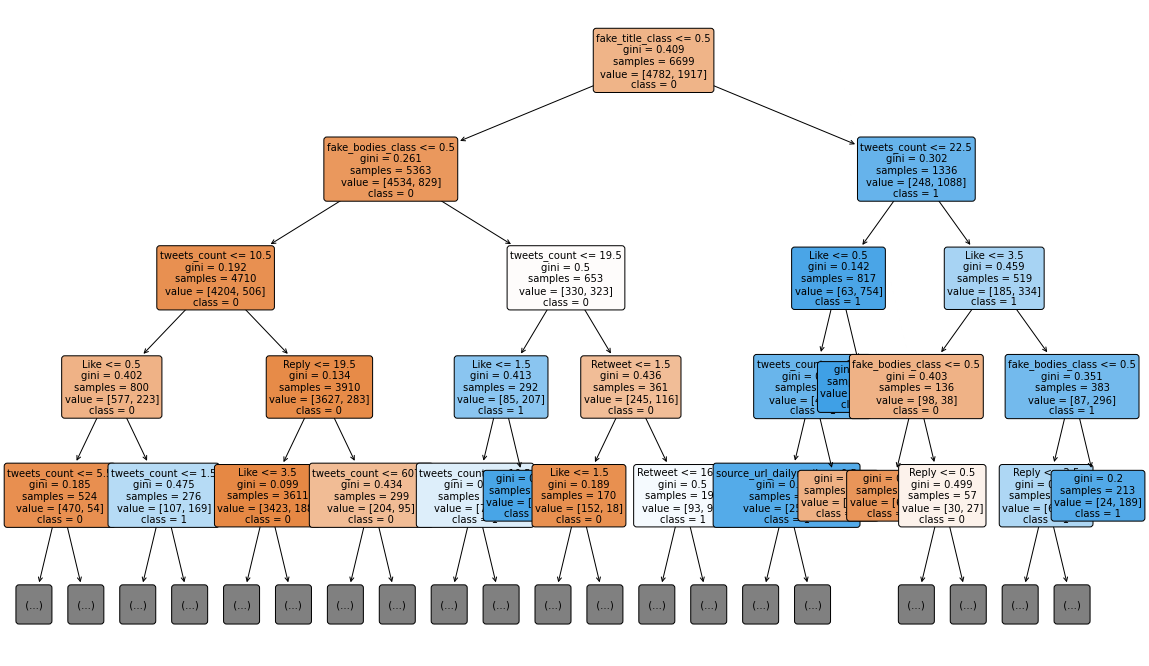

In [ ]:
 # print the Decision tree

from sklearn.tree import plot_tree

print('Node count =', dtc1.tree_.node_count)
plt.figure(figsize=(20,12))
plot_tree(dtc1, 
          feature_names=X_train_class.columns, 
          class_names=['0','1'], 
          max_depth = 4,
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=10) 
plt.show()

In [ ]:
cm_dtc1 = confusion_matrix(y_test, dtc1.predict(X_test_class)).ravel()

acc_dtc1 = acc(cm_dtc1)
tpr_dtc1 = tpr(cm_dtc1)
fpr_dtc1 = fpr(cm_dtc1)
f1_dtc1 = f1(cm_dtc1)

print('Accuracy Decision Tree Classifier :', acc_dtc1)
print('TPR dtc model :', tpr_dtc1, '\nFPR dtc model :', fpr_dtc1)
print('F1 score dtc model :', f1_dtc1)


Accuracy Decision Tree Classifier : 0.812
TPR dtc model : 0.616 
FPR dtc model : 0.11
F1 score dtc model : 0.651


Word2Vec

In [ ]:
# Cross validation

grid_values = {'ccp_alpha': np.linspace(0.0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 
            
dtc = DecisionTreeClassifier()
dtc_cv_acc1 = GridSearchCV(dtc, param_grid = grid_values, scoring = 'f1', cv=10, verbose=1)
dtc_cv_acc1.fit(X_train_class2, y_train2) 

In [ ]:
print('Grid best parameter ccp_alpha (max. CV f1): ', dtc_cv_acc1.best_params_['ccp_alpha'])
print('Grid best score (CV f1): ', dtc_cv_acc1.best_score_)

Grid best parameter ccp_alpha (max. CV f1):  0.0005
Grid best score (CV f1):  0.7826224195185926


In [ ]:
dtc1 = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha= 0.0005, # found by cross validation
                             criterion = 'gini',
                             min_samples_split = 20,
                             max_depth = 30,
                             random_state = 88)

dtc1 = dtc1.fit(X_train_class2, y_train2) #fit the decision tree

Node count = 89


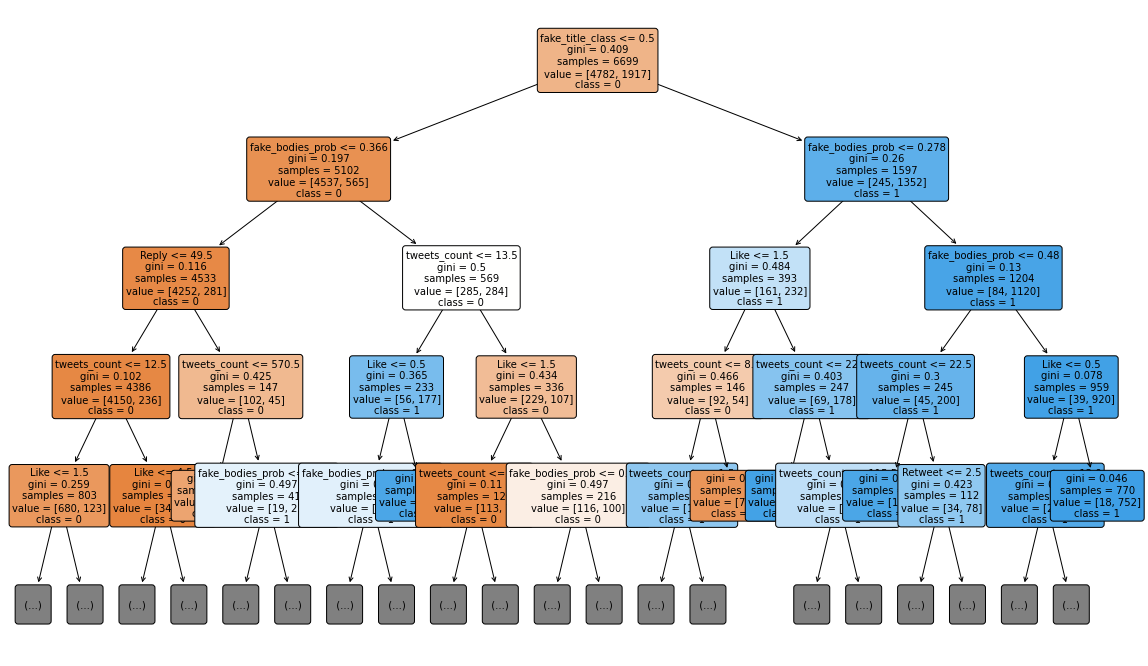

In [ ]:
 # print the Decision tree

from sklearn.tree import plot_tree

print('Node count =', dtc1.tree_.node_count)
plt.figure(figsize=(20,12))
plot_tree(dtc1, 
          feature_names=X_train_class2.columns, 
          class_names=['0','1'], 
          max_depth = 4,
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=10) 
plt.show()

In [ ]:
cm_dtc1 = confusion_matrix(y_test2, dtc1.predict(X_test_class2)).ravel()

acc_dtc1 = acc(cm_dtc1)
tpr_dtc1 = tpr(cm_dtc1)
fpr_dtc1 = fpr(cm_dtc1)
f1_dtc1 = f1(cm_dtc1)

print('Accuracy Decision Tree Classifier :', acc_dtc1)
print('TPR dtc model :', tpr_dtc1, '\nFPR dtc model :', fpr_dtc1)
print('F1 score dtc model :', f1_dtc1)


Accuracy Decision Tree Classifier : 0.774
TPR dtc model : 0.427 
FPR dtc model : 0.089
F1 score dtc model : 0.518


### Random Forest

In [ ]:
# Cross validation for classifier

grid_values = {'max_features': np.linspace(1,60,25, dtype='int32'),
              'min_samples_leaf': [5],
              'n_estimators': [500],
              'random_state': [88]} 

rf = RandomForestClassifier() 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='f1', cv=10)
rf_cv.fit(X_train_class, y_train)

In [ ]:
print('Grid best parameter', rf_cv.best_params_)
print('Grid best score (CV f1 score): ', rf_cv.best_score_)

Grid best parameter {'max_features': 18, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}
Grid best score (CV f1 score):  0.811248889920259


In [ ]:
rf = RandomForestClassifier(max_features=18, # found by cross validation
                            min_samples_leaf=5,
                            n_estimators = 500,
                            random_state=88,
                            verbose=2)
rf.fit(X_train_class2, y_train2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.9s finished


RandomForestClassifier(max_features=18, min_samples_leaf=5, n_estimators=500,
                       random_state=88, verbose=2)

In [ ]:
cm_rf = confusion_matrix(y_test2, rf.predict(X_test_class2)).ravel()

acc_rf = acc(cm_rf)
tpr_rf = tpr(cm_rf)
fpr_rf = fpr(cm_rf)
f1_rf = f1(cm_rf)

print('Accuracy rf :', acc_rf)
print('TPR rf model :', tpr_rf, '\nFPR rf model :', fpr_rf)
print('F1 score rf model :', f1_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy rf : 0.783
TPR rf model : 0.449 
FPR rf model : 0.084
F1 score rf model : 0.541


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


### Gradient Boosting

GloVe

In [ ]:
grid_values = {'max_leaf_nodes': np.linspace(2, 10, 9, dtype='int32'),
               'min_samples_leaf': [10],
               'n_estimators': np.logspace(9, 16, num=8, base=2, dtype='int32'),
               'learning_rate': [0.01],
               'random_state': [88]}

tic = time.time()

gbc1 = GradientBoostingClassifier()
gbc_cv = GridSearchCV(gbc1, param_grid=grid_values, scoring='f1', cv=5)
gbc_cv.fit(X_val_class, y_val)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

time: 8229.58 s


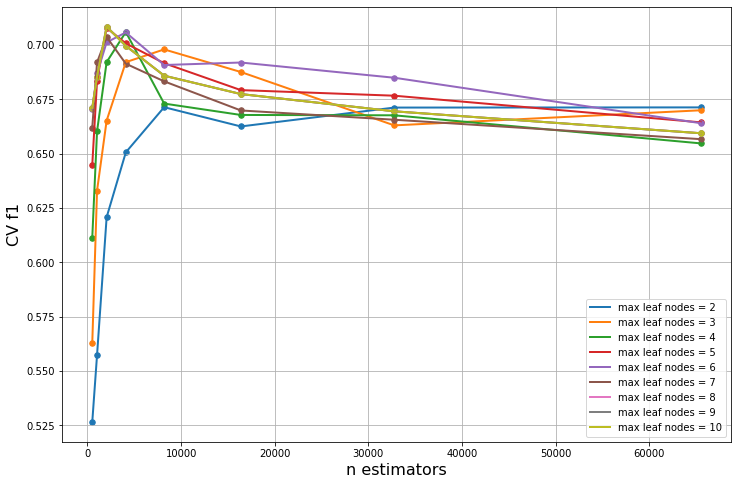

In [ ]:
n_estimators = gbc_cv.cv_results_['param_n_estimators'].data
f1_scores = gbc_cv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 8))
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('CV f1', fontsize=16)
plt.grid(True, which='both')

N = len(grid_values['max_leaf_nodes'])
M = len(grid_values['n_estimators'])
for i in range(N):
    plt.scatter(n_estimators[(M*i):(M*i)+M], f1_scores[(M*i):(M*i)+M], s=30)
    plt.plot(n_estimators[(M*i):(M*i)+M], f1_scores[(M*i):(M*i)+M], linewidth=2,
             label='max leaf nodes = '+str(grid_values['max_leaf_nodes'][i]))
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(gbc_cv.best_params_)

{'learning_rate': 0.01, 'max_leaf_nodes': 8, 'min_samples_leaf': 10, 'n_estimators': 2048, 'random_state': 88}


In [ ]:
cm_gbc = confusion_matrix(y_test, gbc_cv.predict(X_test_class)).ravel()

acc_gbc = acc(cm_gbc)
tpr_gbc = tpr(cm_gbc)
fpr_gbc = fpr(cm_gbc)
f1_gbc = f1(cm_gbc)

print('Accuracy gbc :', acc_gbc)
print('TPR gbc model :', tpr_gbc, '\nFPR gbc model :', fpr_gbc)
print('F1 score gbc model :', f1_gbc)

Accuracy gbc : 0.846
TPR gbc model : 0.63 
FPR gbc model : 0.069
F1 score gbc model : 0.699


Word2Vec

In [ ]:
grid_values = {'max_leaf_nodes': np.linspace(2, 10, 9, dtype='int32'),
               'min_samples_leaf': [10],
               'n_estimators': np.logspace(9, 16, num=8, base=2, dtype='int32'),
               'learning_rate': [0.01],
               'random_state': [88]}

tic = time.time()

gbc1 = GradientBoostingClassifier()
gbc_cv = GridSearchCV(gbc1, param_grid=grid_values, scoring='f1', cv=5)
gbc_cv.fit(X_val_class2, y_val2)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

time: 9902.48 s


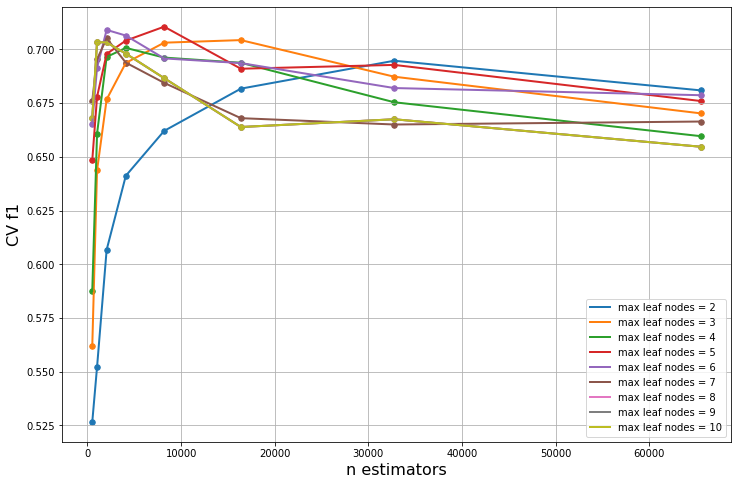

In [ ]:
n_estimators = gbc_cv.cv_results_['param_n_estimators'].data
f1_scores = gbc_cv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 8))
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('CV f1', fontsize=16)
plt.grid(True, which='both')

N = len(grid_values['max_leaf_nodes'])
M = len(grid_values['n_estimators'])
for i in range(N):
    plt.scatter(n_estimators[(M*i):(M*i)+M], f1_scores[(M*i):(M*i)+M], s=30)
    plt.plot(n_estimators[(M*i):(M*i)+M], f1_scores[(M*i):(M*i)+M], linewidth=2,
             label='max leaf nodes = '+str(grid_values['max_leaf_nodes'][i]))
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(gbc_cv.best_params_)

{'learning_rate': 0.01, 'max_leaf_nodes': 5, 'min_samples_leaf': 10, 'n_estimators': 8192, 'random_state': 88}


In [ ]:
cm_gbc = confusion_matrix(y_test2, gbc_cv.predict(X_test_class2)).ravel()

acc_gbc = acc(cm_gbc)
tpr_gbc = tpr(cm_gbc)
fpr_gbc = fpr(cm_gbc)
f1_gbc = f1(cm_gbc)

print('Accuracy gbc :', acc_gbc)
print('TPR gbc model :', tpr_gbc, '\nFPR gbc model :', fpr_gbc)
print('F1 score gbc model :', f1_gbc)

Accuracy gbc : 0.834
TPR gbc model : 0.638 
FPR gbc model : 0.088
F1 score gbc model : 0.686


### XGBoost

In [ ]:
grid_values = {'max_leaf_nodes': np.linspace(2, 10, 9, dtype='int32'),
               'min_samples_leaf': [10],
               'n_estimators': np.logspace(9, 16, num=8, base=2, dtype='int32'),
               'learning_rate': [0.01],
               'random_state': [88]}

tic = time.time()

xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb, param_grid=grid_values, scoring='f1', cv=5)
xgb_cv.fit(X_val_class, y_val)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

time: 3599.53 s


In [ ]:
print(xgb_cv.best_params_)

{'learning_rate': 0.01, 'max_leaf_nodes': 2, 'min_samples_leaf': 10, 'n_estimators': 2048, 'random_state': 88}


In [ ]:
xgb_cv = XGBClassifier(n_estimators=2048, learning_rate= 0.001, random_state=88, verbose=1,
                                max_leaf_nodes=2, min_samples_leaf =  10) 

In [ ]:
xgb_cv=xgb_cv.fit(X_train_class, y_train)

In [ ]:
cm_xgb = confusion_matrix(y_test, xgb_cv.predict(X_test_class)).ravel()

acc_xgb = acc(cm_xgb)
tpr_xgb = tpr(cm_xgb)
fpr_xgb = fpr(cm_xgb)
f1_xgb = f1(cm_xgb)

print('Accuracy gbc :', acc_xgb)
print('TPR gbc model :', tpr_xgb, '\nFPR gbc model :', fpr_xgb)
print('F1 score gbc model :', f1_xgb)

Accuracy gbc : 0.766
TPR gbc model : 0.436 
FPR gbc model : 0.103
F1 score gbc model : 0.514
